# Time series prediction with LSTM (IOT Data) in keras

### Description

Name : K.S,SUH
Date: 2017.07.29 KST(seoul) 16:55 PM

  
In this notebook,  I want to build a model using some real world internet-of-things (IOT) data. As an example I want to predict the daily output of a solar panel base on the initial readings of the day. This notebook focusses on a simplified forecasting model using previously generated data from solar panel to predict the future. In completing this notebook I will show you how to construct RNNs using Keras

For more details -> https://en.wikipedia.org/wiki/Solar_power_forecasting

### Goal

Using historic daily production of a solar panel, I want to predict the total power production of the solar panel array for a future day. I will be using an LSTM based time series prediction model to predict the daily output of a solar panel based on the initial readings of a the day.

I will train the model with historical data of the solar panel. In this activity, I want to predict the total power production of the solar panel array for the day starting with the initial readings of the day.




## Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.


For more details -> http://colah.github.io/posts/2015-08-Understanding-LSTMs/



## Import Dependencies

In [34]:
from matplotlib import pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import time
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)


try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
    
%matplotlib inline

## Data Loading Helper Functions

In [35]:
def download_data(input_url):
    """
    generate sequences to feed to rnn based on data frame with solar panel data
    the csv has the format : time , solar.current, solar.total
    """
    # Try to find the data file local.If it does not exists download it
    cache_path = os.path.join("data", "iot")
    cache_file = os.path.join(cache_path, "solar.csv")
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    if not os.path.exists(cache_file):
        urlretrieve(input_url, cache_file)
        print("downloaded data successfully from", input_url)
    else:
        print("using cache for", input_url)

In [36]:
download_data("https://www.cntk.ai/jup/dat/solar.csv")

using cache for https://www.cntk.ai/jup/dat/solar.csv


In [37]:
cache_path = os.path.join("data", "iot")
cache_file = os.path.join(cache_path, "solar.csv")
df = pd.read_csv(cache_file,usecols=[2], engine='python', skipfooter=3)

In [38]:
df.head()

,solar.total
0,1.69
1,11.36
2,67.50
3,250.50
4,573.50


In [39]:
df = df.values

In [40]:
df 

array([[  1.69000006e+00],
       [  1.13599999e+01],
       [  6.75000000e+01],
       ..., 
       [  1.41000000e+03],
       [  1.99000000e+03],
       [  2.74500000e+03]])

In [41]:
df = df.astype('float32')

In [42]:
df

array([[  1.69000006e+00],
       [  1.13599997e+01],
       [  6.75000000e+01],
       ..., 
       [  1.41000000e+03],
       [  1.99000000e+03],
       [  2.74500000e+03]], dtype=float32)

## normalize the dataset

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

In [44]:
df

array([[  8.84816764e-05],
       [  5.94764366e-04],
       [  3.53403133e-03],
       ..., 
       [  7.38219842e-02],
       [  1.04188479e-01],
       [  1.43717274e-01]], dtype=float32)

## Simple plot the dataset

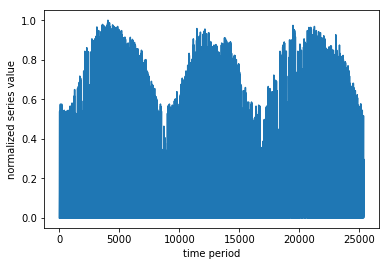

In [45]:
plt.xlabel('time period')
plt.ylabel('normalized series value')
plt.plot(df)

## Cutting our time series into sequences
our time series is a sequence of numbers that we can represent in general mathematically as
                  $$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series. In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.
For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs.

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value. Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5 input/output pairs. More generally, for a window size T we create P - T such pairs

So, The following is to window the input time series as described above!

In [46]:
# helper function that transforms the input series and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    for i in range(0,len(series)-window_size-1):
        # output saved
        y.append(series[i+window_size]) 
        # auxiliar variable to save the input
        aux = [] 
        
        for j in range(i,window_size+i):
            aux.append(series[j])   
        # input saved
        X.append(aux) # input saved
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

###  Test the function on the list of odd numbers given below

In [47]:
odd_nums = np.array([1,3,5,7,9,11,13])

### Get the relevant input/output pairs to window this sequence with a window_size = 2 using the window_transform_series 

In [48]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[1 3]
 [3 5]
 [5 7]
 [7 9]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]]
the shape of X is (4, 2)
the shape of y is (4, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


In [49]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = df,window_size = window_size)

## Splitting into training and testing sets
In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing). This is that once we train our model we have something to test it on (like any regression problem!). This splitting into training/testing sets is done in the cell below.


In [50]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Building and run an RNN regression model
Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN. We 
use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))

- layer 2 uses a fully connected module with one unit

- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

### Building the model architecture

In [51]:
#createRNN model 
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# build an RNN to perform regression on our time series input/output data
# secuential model
model = Sequential()
#add a LSTM layer with 5 hidden units
model.add(LSTM(5, input_shape=(window_size, 1))) 
# add a fully connected layer with 1 unit
model.add(Dense(1)) 
model.summary()

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146.0
Trainable params: 146
Non-trainable params: 0.0
_________________________________________________________________


## Training the model
Run the model here. Experiment with different batch_size, and number of epochs!

In [55]:
hist1 = model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0)

In [57]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [58]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = [0.013234910705905439, 0.0020111203123151546]
testing error = [0.019008264335182438, 0.0052058684335068621]


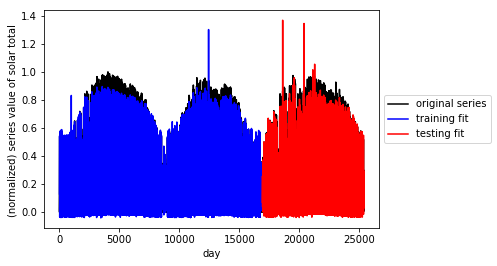

In [61]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) series value of solar total ')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Conclusion

I compute training and testing errors using our trained model and successfully able to achieve 
training_error < 0.02 with only number of 10 epochs including beautiful visualization! 

For accuracy, I can use up to 1000 epochs but My local machine would take so much time  though...

